In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pykeen
import matplotlib.pyplot as plt
import torch
from pykeen.datasets import Nations, WN18RR
from pykeen.pipeline import pipeline
from pykeen import predict
from statistics import mean, median
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
from pyvis.network import Network
from ipywidgets import interact, interact_manual
import ipywidgets as widgets
from itertools import chain
from pathlib import Path
from rich import print
import plwordnet
import random
from pykeen.triples import TriplesFactory
from pykeen.datasets import EagerDataset

from utils import prepare_for_visualization

2023-06-14 17:17:48.350651: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-14 17:17:48.877417: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Settings

In [3]:
pd.set_option("display.float_format", lambda x: "%.5f" % x)

## Loading data

In [4]:
WORDNET_PATH = Path("data/plwordnet/plwordnet_4_2.xml")

In [6]:
wn = plwordnet.load(str(WORDNET_PATH))
print(wn)

Słowosieć
  lexical units: 513410
  synsets: 353585
  relation types: 306
  synset relations: 1477851
  lexical relations: 393137
  emotional annotations: 0
  rich descriptions: 0

In [7]:
def filter_pos_synsets(synsets:list, pos:str) -> list:
    return [s_id for s_id, s in synsets.items() if all([lu.pos == pos for lu in s.lexical_units])]

In [8]:
filtered_synsets = filter_pos_synsets(wn.synsets, "NOUN")

In [9]:
sampled_synsets = set(random.sample(filtered_synsets, 150000))
sampled_relations = set(list(sorted(wn.relation_types.keys()))[:50])

In [10]:
sampled = [
    (h, r, t)
    for h, r, t, in wn.synset_relations
    if r in sampled_relations and h in sampled_synsets and t in sampled_synsets
]
sampled = np.array(sampled)

In [11]:
labeled_sampled = np.array(
    [
        (str(wn.synsets[h]), str(wn.relation_types[r].name), str(wn.synsets[t]))
        for h, r, t, in sampled
    ]
)
labeled_sampled[:2]

array([['{rozmowa.1 konwersacja.1 dialog.1 dyskurs.1}', 'hiperonimia',
        '{dyskusja.1 dysputa.1 debata.1 debatowanie.3 dysputacja.1}'],
       ['{dyskusja.1 dysputa.1 debata.1 debatowanie.3 dysputacja.1}',
        'hiponimia', '{rozmowa.1 konwersacja.1 dialog.1 dyskurs.1}']],
      dtype='<U420')

In [17]:
triples = TriplesFactory.from_labeled_triples(labeled_sampled, create_inverse_triples=True)

In [18]:
training, testing = triples.split(0.95)

using automatically assigned random_state=1871817341


In [19]:
dataset = EagerDataset(training, testing)

## Training 

In [20]:
from pykeen.nn.modules import TransEInteraction

In [ ]:
result = pipeline(
    dataset=dataset,
    model="NodePiece",
    model_kwargs={"embedding_dim": 256, "num_tokens":20},
    loss="nssa",
    loss_kwargs={"adversarial_temperature": 0.34, "margin": 9},
    optimizer="Adam",
    optimizer_kwargs={"lr": 0.004},
    negative_sampler_kwargs={"num_negs_per_pos": 33},
    training_kwargs=dict(
        num_epochs=25,
        batch_size=512,
        use_tqdm_batch=True,
    ),
    random_seed=123,
)

INFO:pykeen.pipeline.api:Using device: None


sampling:   0%|          | 0.00/66.5k [00:00<?, ?it/s]

INFO:pykeen.triples.triples_factory:Creating inverse triples.


Training epochs on cpu:   0%|          | 0/25 [00:00<?, ?epoch/s]

INFO:pykeen.triples.triples_factory:Creating inverse triples.


Training batches on cpu:   0%|          | 0/545 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/545 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/545 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/545 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/545 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/545 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/545 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/545 [00:00<?, ?batch/s]

In [23]:
save_location = Path("results")
save_location.mkdir(exist_ok=True)
result.save_to_directory(save_location)
print(f"Saved: {os.listdir(save_location)}")

INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=66546, num_relations=24, create_inverse_triples=True, num_triples=139517) to file:///home/albert/dev/kg-workshop-23/results/training_triples
INFO:pykeen.pipeline.api:Saved to directory: file:///home/albert/dev/kg-workshop-23/results


Saved: ['metadata.json', 'results.json', 'training_triples', 'trained_model.pkl']

## Metrics

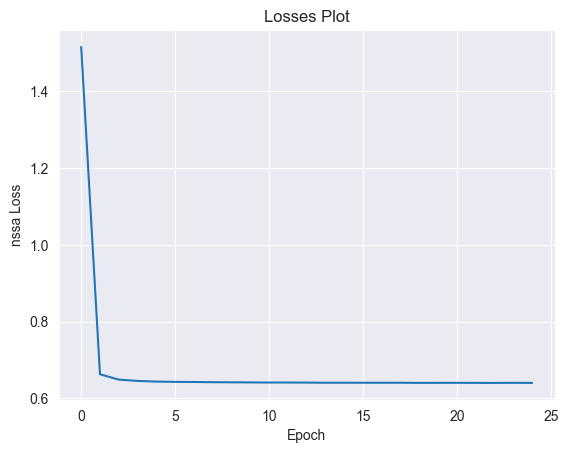

In [24]:
result.plot_losses()
plt.show()

In [25]:
metrics = result.metric_results.to_df()

In [26]:
metrics[(metrics.Side == "both") & (metrics.Type == "realistic")]

,Side,Type,Metric,Value
5,both,realistic,geometric_mean_rank,17463.89648
14,both,realistic,median_absolute_deviation,26692.77034
23,both,realistic,adjusted_geometric_mean_rank_index,0.28655
32,both,realistic,z_inverse_harmonic_mean_rank,6.90364
41,both,realistic,harmonic_mean_rank,2180.11105
50,both,realistic,inverse_harmonic_mean_rank,0.00046
59,both,realistic,inverse_geometric_mean_rank,0.00006
68,both,realistic,variance,560497600.00000
77,both,realistic,arithmetic_mean_rank,30049.69727
86,both,realistic,median_rank,20647.00000


## Embeddings visualization

In [27]:
model = result.model
model

NodePiece(
  (loss): NSSALoss()
  (interaction): DistMultInteraction()
  (entity_representations): ModuleList(
    (0): NodePieceRepresentation(
      (base): ModuleList(
        (0): TokenizationRepresentation(
          (vocabulary): Embedding(
            (_embeddings): Embedding(25, 32)
          )
        )
      )
      (combination): ConcatAggregationCombination()
    )
  )
  (relation_representations): ModuleList(
    (0): SubsetRepresentation(
      (base): Embedding(
        (_embeddings): Embedding(25, 32)
      )
    )
  )
  (weight_regularizers): ModuleList()
)

In [28]:
result.model.entity_representations[0]#.combined.entity_representations#(torch.tensor[0])

NodePieceRepresentation(
  (base): ModuleList(
    (0): TokenizationRepresentation(
      (vocabulary): Embedding(
        (_embeddings): Embedding(25, 32)
      )
    )
  )
  (combination): ConcatAggregationCombination()
)

In [30]:
embeddings = result.model.entity_representations[0](torch.arange(dataset.num_entities))
labels = np.array(
    [dataset.training.entity_id_to_label[i] for i in range(dataset.num_entities)]
)

In [ ]:
result.model.entity_representations[0]

In [ ]:
embeddings = result.model.entity_representations[0].combined.enriched_representations[0]

In [31]:
len(embeddings)

66546

In [32]:
sampled_embeddings_idx = random.sample(list(range(len(embeddings))), 5000)

In [33]:
prepare_for_visualization(
    embeddings.detach().numpy()[sampled_embeddings_idx],
    labels[sampled_embeddings_idx],
    Path("logs/plwordnet"),
)

In [34]:
!tensorboard --logdir=logs/plwordnet 

2023-06-14 17:28:02.034840: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.12.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C
